<a href="https://colab.research.google.com/github/Marcin19721205/WSBNeuronowe/blob/main/CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wstęp

Normalizacja i standaryzacja należą do najważniejszych operacji, jakie należy przeprowadzić przed przystąpieniem do prowadzenia eksperymentu uczenia maszynowego. Ze względu na fakt, że sieci neuronowe są aktywowane na podstawie podbudzenia (sumy wejść), jest bardzo ważne, żeby różnice w jedostkach nie były na tyle znaczące, by zaburzać proces. W ramach tego notebooka przyjrzymy się metodom normalizacji i standaryzacji - od postych do dużo bardziej złożonych.

In [1]:
%pip install keras_tuner #biblioteka do automatycznego strojenia hiperparametrów modeli Keras/TensorFlow

In [2]:
import gc #garbage collector, Daje dostęp do mechanizmów sprzątania pamięci w Pythonie
import os #Moduł systemowy, do ustawiania ścieżek, tworzenia katalogów, sprawdzania czy plik istnieje itp

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
%matplotlib inline
#Wszystkie wykresy z Matplotlib mają się wyświetlać wewnątrz komórki notebooka

#Wczytanie danych

W ramach tego ćwiczenia będziemy pracować na zbiorze danych California Housing opisującym ceny mieszkań w Kaliforni z lat 90-tych XX wieku. Dane zbierane były podczas spisu powszechnego i zostały pogrupowane według tzw. bloków, czyli podgrup o podobnym profilu. Zadaniem będzie przewidzenie mediany cen mieszkań dla określonych dzielnic.

Zbiór danych składa się z następujących cech, opisanych bardzo rożnymi cechami, o zmiennych zakresach wartości:



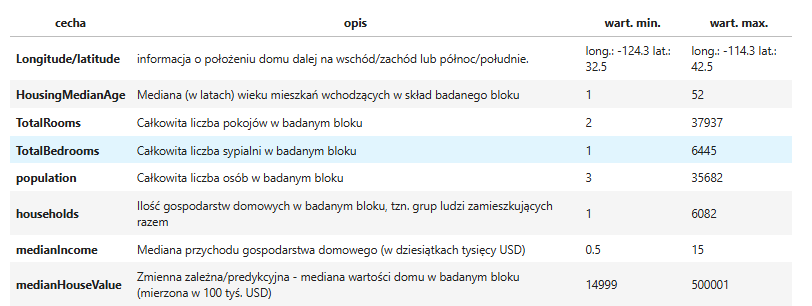

Zmienne nie są znormalizowane, wyrażono je w różnych jednostkach, zbiór zawiera także wartości odstające, tzn. znacznie wykraczające poza pożądany zakres wartości.

In [4]:
from sklearn.datasets import fetch_california_housing

In [5]:
california = fetch_california_housing()

# ### Opis danych California Housing
print("=== OPIS ZBIORU DANYCH ===")
print(california.DESCR)

# --- Dodatkowy, praktyczny opis w formie DataFrame ---
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target

print("\n=== Rozmiar danych ===")
print(df.shape)

print("\n=== Podgląd danych ===")
print(df.head())

print("\n=== Statystyki opisowe ===")
print(df.describe())

print("\n=== Braki danych w kolumnach ===")
print(df.isna().sum())

=== OPIS ZBIORU DANYCH ===
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. c

In [6]:
X = pd.DataFrame(california.data, columns=california.feature_names) # tworzy tabelę cech z danych NumPy i nazwami kolumn jako zmienną X,
y = california.target #wydobywa zmienną target
X.head() #pokazuje 5 pierwszych wierszy tabeli X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
X.describe() #staystyka opisowa

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [8]:
X.describe().T #staystyka opisowa transponowana

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


#Uczenie sieci nieznormalizowanej

Dla porównania, zbudujemy dwa modele na oryginalnych danych, aby zobaczyć skalę problemu i wpływu braku normalizacji danych.

In [9]:
from sklearn.dummy import DummyRegressor

# Kopia danych nieznormalizowanych
X_nonnormal = X.copy()
y_nonnormal = california.target.copy()

#Podział train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_nonnormal, y_nonnormal, #dla nie znormalizowanych
    test_size=0.2,
    random_state=123
)

#Model bazowy: DummyRegressor ---
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

#Sieć neuronowa na nieznormalizowanych danych ---
tf.random.set_seed(123)
np.random.seed(123)

model_non = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model_non.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
    ]
)

history_non = model_non.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

y_pred_nn = model_non.predict(X_test).flatten()

#Porównanie metryk MSE i MAPE
mse_dummy  = mean_squared_error(y_test, y_pred_dummy)
mape_dummy = mean_absolute_percentage_error(y_test, y_pred_dummy)

mse_nn  = mean_squared_error(y_test, y_pred_nn)
mape_nn = mean_absolute_percentage_error(y_test, y_pred_nn)

print("DummyRegressor -> MSE:  {:.4f}, MAPE: {:.4f}".format(mse_dummy,  mape_dummy))
print("Neural Network -> MSE:  {:.4f}, MAPE: {:.4f}".format(mse_nn,    mape_nn))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 356.4376 - mae: 7.4550 - mape: 480.1740 - val_loss: 5.3091 - val_mae: 2.0119 - val_mape: 100.9341
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2474 - mae: 1.9824 - mape: 97.9000 - val_loss: 5.1281 - val_mae: 1.9644 - val_mape: 97.6293
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.0592 - mae: 1.9340 - mape: 95.5152 - val_loss: 4.8429 - val_mae: 1.8796 - val_mape: 92.9696
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6006 - mae: 1.8140 - mape: 90.9702 - val_loss: 3.7704 - val_mae: 1.5786 - val_mape: 81.1263
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7328 - mae: 1.2866 - mape: 69.0235 - val_loss: 1.2766 - val_mae: 0.7910 - val_mape: 41.7012
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1095 - mae: 0.7670 - mape: 45.4334 - val_loss: 1.0498 - val_mae: 0.7290 - val_mape: 36.8255
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9022 - mae

In [10]:
# --- Ewaluacja modelu nienormalizowanego ---

# Predykcje sieci
y_pred_nn_non = model_non.predict(X_test).flatten()

# Metryki MSE, MAPE
mape_non = mean_absolute_percentage_error(y_test, y_pred_nn_non)
mse_non  = mean_squared_error(y_test, y_pred_nn_non)

print(f"MAPE (nn_non): {mape_non}")
print(f"MSE  (nn_non): {mse_non}")

# Kontrolny assert (opcjonalny)
# assert 0.40 <= mape_non <= 0.70


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE (nn_non): 0.45312699348402397
MSE  (nn_non): 1.2036963648092724


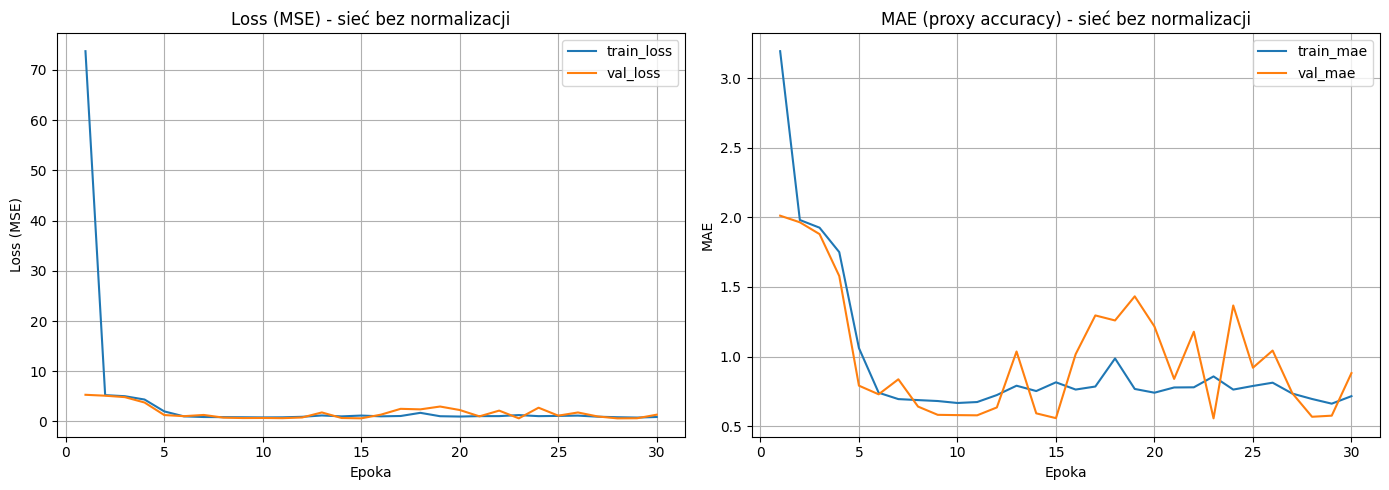

In [11]:
# --- Wykresy: LOSS + MAE dla sieci bez normalizacji ---

history_non_dict = history_non.history
epochs_non = range(1, len(history_non_dict['loss']) + 1)

plt.figure(figsize=(14, 5))

# 1. LOSS (MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_non, history_non_dict['loss'], label='train_loss')
plt.plot(epochs_non, history_non_dict['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) - sieć bez normalizacji')
plt.legend()
plt.grid(True)

# 2. MAE (treat like accuracy curve)
plt.subplot(1, 2, 2)
plt.plot(epochs_non, history_non_dict['mae'], label='train_mae')
plt.plot(epochs_non, history_non_dict['val_mae'], label='val_mae')
plt.xlabel('Epoka')
plt.ylabel('MAE')
plt.title('MAE (proxy accuracy) - sieć bez normalizacji')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#Skalowanie min-max

Sprawdzimy teraz wpływ skalowania min-max na wyniki uzyskiwane przez sieć neuronową.

Zadanie: przeprowadźmy prosty ekspertyment:
Utwórz obiekty typu MinMax Scaler z pakietu Sklearn.
Przetrenuj go na danych treningowych X, a następnie przetransformuj z jego użyciem dane treningowe i testowe, zapisując do osobnej zmiennej.
Wyszkol model sieci neuronowej o identycznzej architekutrze jak przedtem, ale posługując się danymi przeskalowanymi techniką Min-Max.
Dla sieci neurnowej użyj metryk: mean_absolute_error, mean_absolute_percentage_error
Porównaj otrzymane wyniki z poprzednią siecią i regresorem do średniej, na przeskalowanych danych testowych używając metryk MSE, MAPE

In [12]:
from sklearn.preprocessing import MinMaxScaler

# --- 1. Skalowanie Min-Max danych wejściowych (train + test) ---

scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)   # uczymy skaler na train
X_test_minmax  = scaler_minmax.transform(X_test)        # ten sam skaler na test

# --- 2. Sieć neuronowa o identycznej architekturze jak wcześniej, ale na danych Min-Max ---

tf.random.set_seed(123)
np.random.seed(123)

model_minmax = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train_minmax.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model_minmax.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
    ]
)

history_minmax = model_minmax.fit(
    X_train_minmax, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

# --- 3. Predykcje na danych PRZESKALOWANYCH ---

y_pred_nn_minmax = model_minmax.predict(X_test_minmax).flatten()

# DummyRegressor na przeskalowanych danych testowych
y_pred_dummy_minmax = dummy.predict(X_test_minmax)

# --- 4. Metryki MSE, MAPE dla Min-Max (sieć vs Dummy) ---

mse_dummy_minmax  = mean_squared_error(y_test, y_pred_dummy_minmax)
mape_dummy_minmax = mean_absolute_percentage_error(y_test, y_pred_dummy_minmax)

mse_nn_minmax  = mean_squared_error(y_test, y_pred_nn_minmax)
mape_nn_minmax = mean_absolute_percentage_error(y_test, y_pred_nn_minmax)

print("Dummy (MinMax)   -> MSE: {:.4f}, MAPE: {:.4f}".format(mse_dummy_minmax,  mape_dummy_minmax))
print("NN MinMax        -> MSE: {:.4f}, MAPE: {:.4f}".format(mse_nn_minmax,     mape_nn_minmax))




Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6519 - mae: 1.2447 - mape: 64.2476 - val_loss: 1.2504 - val_mae: 0.8784 - val_mape: 60.2127
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2355 - mae: 0.8818 - mape: 61.0568 - val_loss: 0.9186 - val_mae: 0.7533 - val_mape: 50.6114
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8238 - mae: 0.7023 - mape: 46.5225 - val_loss: 0.5991 - val_mae: 0.5660 - val_mape: 33.4315
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6113 - mae: 0.5784 - mape: 35.2167 - val_loss: 0.5794 - val_mae: 0.5539 - val_mape: 32.2360
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5911 - mae: 0.5652 - mape: 33.9158 - val_loss: 0.5671 - val_mae: 0.5455 - val_mape: 31.5520
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5769 - mae: 0.5568 - mape: 33.2309 - val_loss: 0.5557 - val_mae: 0.5379 - val_mape: 30.8938
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5646 - mae: 0.5493 - mape

In [13]:
# --- Ewaluacja modelu skalowanego Min-Max ---

# Predykcje sieci (skalowane wejście!)
y_pred_nn_minmax = model_minmax.predict(X_test_minmax).flatten()

# Metryki MSE, MAPE
mape_minmax = mean_absolute_percentage_error(y_test, y_pred_nn_minmax)
mse_minmax  = mean_squared_error(y_test, y_pred_nn_minmax)

print(f"MAPE (nn_minmax): {mape_minmax}")
print(f"MSE  (nn_minmax): {mse_minmax}")

# Kontrolny assert — typowo mniejsze MAPE niż w nn_non
# assert 0.25 <= mape_minmax <= 0.45


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE (nn_minmax): 0.2578109178566138
MSE  (nn_minmax): 0.44106206251184454


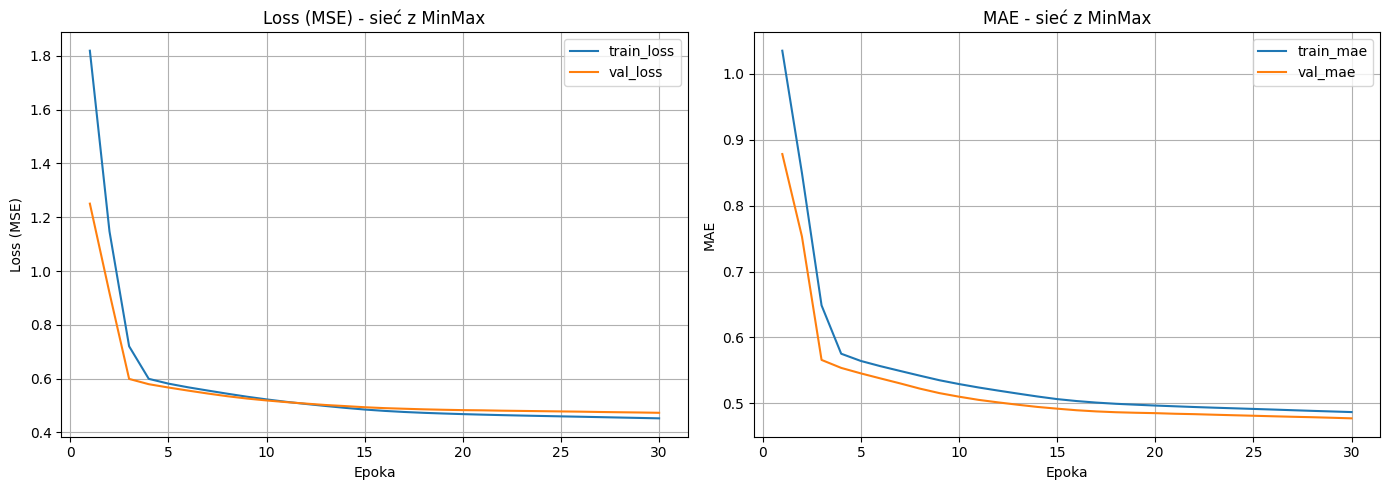

In [14]:
# --- 5. Wykresy: LOSS + MAE dla sieci z Min-Max ---

history_minmax_dict = history_minmax.history
epochs_minmax = range(1, len(history_minmax_dict['loss']) + 1)

plt.figure(figsize=(14, 5))

# 1. LOSS (MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_minmax, history_minmax_dict['loss'],     label='train_loss')
plt.plot(epochs_minmax, history_minmax_dict['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) - sieć z MinMax')
plt.legend()
plt.grid(True)

# 2. MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_minmax, history_minmax_dict['mae'],     label='train_mae')
plt.plot(epochs_minmax, history_minmax_dict['val_mae'], label='val_mae')
plt.xlabel('Epoka')
plt.ylabel('MAE')
plt.title('MAE - sieć z MinMax')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Standaryzacja danych

In [15]:
from sklearn.preprocessing import StandardScaler

# --- Standaryzacja danych ---
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)   # uczymy skaler na train
X_test_std  = scaler_std.transform(X_test)        # ten sam skaler na test

# --- Sieć neuronowa (taka sama architektura jak wcześniej) ---
tf.random.set_seed(123)
np.random.seed(123)

model_std = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train_std.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model_std.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
    ]
)

history_std = model_std.fit(
    X_train_std, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 2.9742 - mae: 1.3253 - mape: 64.4660 - val_loss: 0.7412 - val_mae: 0.6131 - val_mape: 36.5820
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6657 - mae: 0.5982 - mape: 36.0666 - val_loss: 0.5301 - val_mae: 0.5152 - val_mape: 29.8518
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.5135 - mae: 0.5130 - mape: 29.7233 - val_loss: 0.4593 - val_mae: 0.4819 - val_mape: 27.7116
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.4517 - mae: 0.4787 - mape: 27.6978 - val_loss: 0.4286 - val_mae: 0.4657 - val_mape: 27.0540
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.4202 - mae: 0.4612 - mape: 27.0081 - val_loss: 0.4123 - val_mae: 0.4562 - val_mape: 26.7506
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4040 - mae: 0.4510 - mape: 26.6163 - val_loss: 0.4070 - val_mae: 0.4521 - val_mape: 26.7265
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3952 - mae

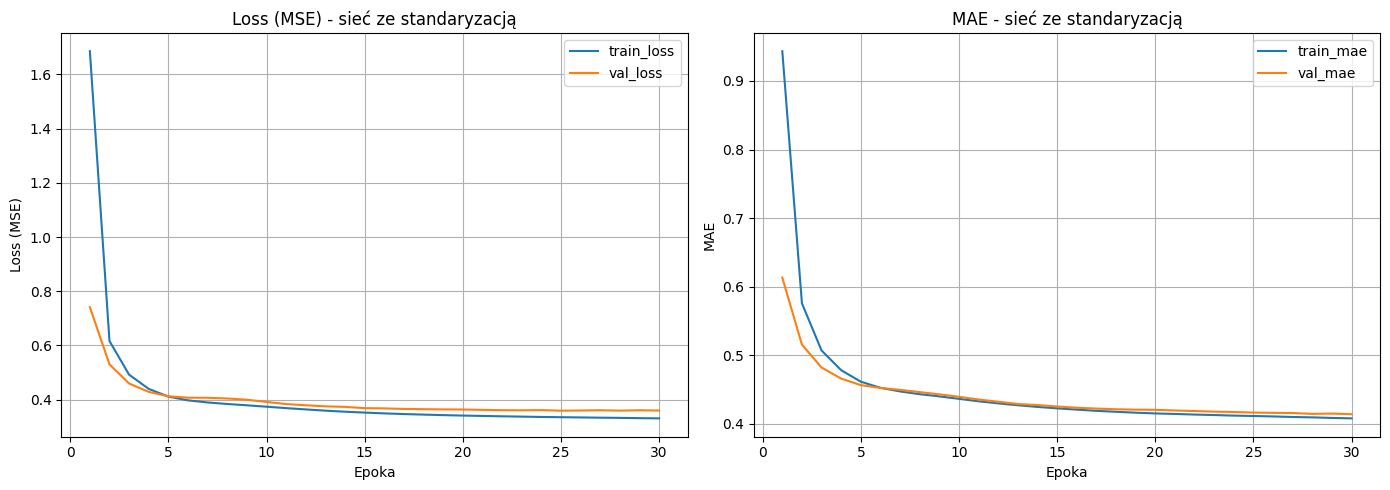

In [16]:
# --- Wykresy: LOSS + MAE dla sieci ze standaryzacją ---

history_std_dict = history_std.history
epochs_std = range(1, len(history_std_dict['loss']) + 1)

plt.figure(figsize=(14, 5))

# 1. LOSS (MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_std, history_std_dict['loss'],     label='train_loss')
plt.plot(epochs_std, history_std_dict['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) - sieć ze standaryzacją')
plt.legend()
plt.grid(True)

# 2. MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_std, history_std_dict['mae'],     label='train_mae')
plt.plot(epochs_std, history_std_dict['val_mae'], label='val_mae')
plt.xlabel('Epoka')
plt.ylabel('MAE')
plt.title('MAE - sieć ze standaryzacją')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# --- Błędy na danych testowych dla modelu standaryzowanego ---

# Predykcje sieci
y_pred_nn_std = model_std.predict(X_test_std).flatten()

mape_std = mean_absolute_percentage_error(y_test, y_pred_nn_std)
mse_std  = mean_squared_error(y_test, y_pred_nn_std)

print(f"MAPE (nn_std): {mape_std}")
print(f"MSE  (nn_std): {mse_std}")

# (opcjonalnie) ten sam DummyRegressor na X_test_std
#y_pred_dummy_std = dummy.predict(X_test_std)
#mape_dummy_std = mean_absolute_percentage_error(y_test, y_pred_dummy_std)
#mse_dummy_std  = mean_squared_error(y_test, y_pred_dummy_std)

#print(f"MAPE (dummy_std): {mape_dummy_std}")
#print(f"MSE  (dummy_std): {mse_dummy_std}")

# ewentualny prosty test zakresu
# assert 0.25 <= mape_std <= 0.45


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE (nn_std): 0.24234994928806466
MSE  (nn_std): 0.32540598336593446


#Batch Norm

W tej części notebooka wykorzystamy technikę, która pozwala sieci neuronowej przeprowadzić normalizację danych "według uznania", tzn. w taki sposób, który będzie najlepiej poprawiał uzyskiwane przez nią wyniki. Uzyskamy to dzięki dodaniu nowej warstwy: 'batch norm' na samym początku sieci.

In [18]:
from tensorflow.keras.layers import BatchNormalization

# --- Model z Batch Normalization na wejściu ---

tf.random.set_seed(123)
np.random.seed(123)

model_bn = tf.keras.Sequential([
    BatchNormalization(input_shape=(X_train.shape[1],)),         # <-- BatchNorm na wejściu
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model_bn.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
    ]
)

history_bn = model_bn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.8604 - mae: 1.5321 - mape: 72.3284 - val_loss: 1.6895 - val_mae: 0.6875 - val_mape: 47.6657
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6610 - mae: 0.5947 - mape: 35.4555 - val_loss: 9.3601 - val_mae: 0.5656 - val_mape: 34.4473
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5195 - mae: 0.5225 - mape: 31.3051 - val_loss: 10.7500 - val_mae: 0.5551 - val_mape: 33.1748
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4876 - mae: 0.5034 - mape: 29.9601 - val_loss: 10.3712 - val_mae: 0.5460 - val_mape: 32.4046
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4722 - mae: 0.4944 - mape: 29.3075 - val_loss: 9.7654 - val_mae: 0.5388 - val_mape: 31.8003
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4631 - mae: 0.4885 - mape: 28.8430 - val_loss: 9.0333 - val_mae: 0.5324 - val_mape: 31.1508
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4551 - mae: 0.4832 - ma

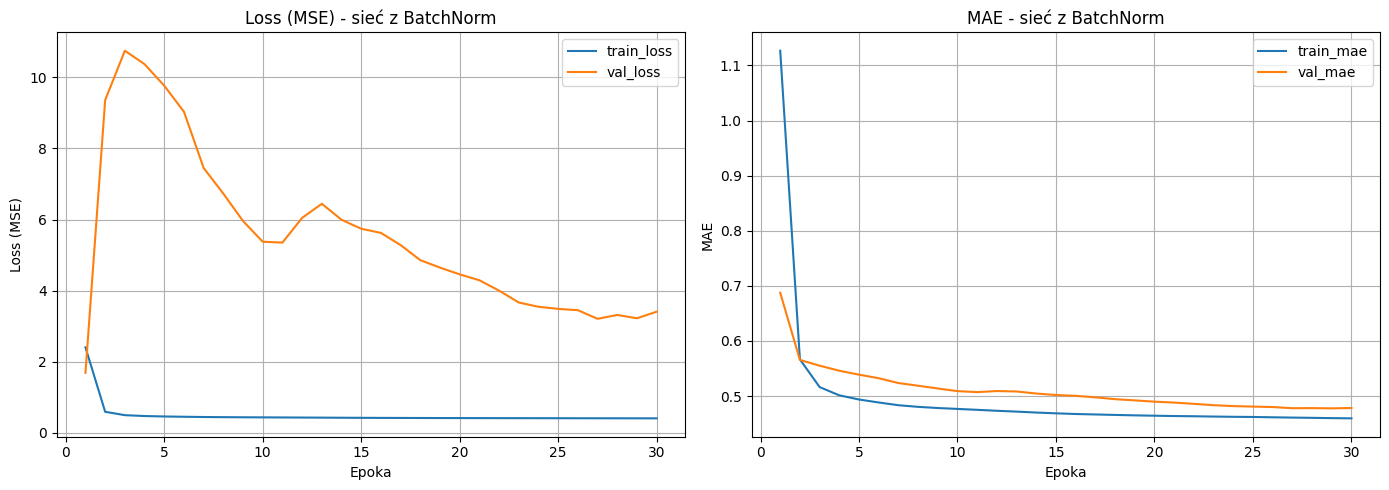

In [19]:
# --- Wykresy dla BatchNorm ---

history_bn_dict = history_bn.history
epochs_bn = range(1, len(history_bn_dict['loss']) + 1)

plt.figure(figsize=(14, 5))

# 1. LOSS (MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_bn, history_bn_dict['loss'],     label='train_loss')
plt.plot(epochs_bn, history_bn_dict['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) - sieć z BatchNorm')
plt.legend()
plt.grid(True)

# 2. MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_bn, history_bn_dict['mae'],     label='train_mae')
plt.plot(epochs_bn, history_bn_dict['val_mae'], label='val_mae')
plt.xlabel('Epoka')
plt.ylabel('MAE')
plt.title('MAE - sieć z BatchNorm')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
# --- Ewaluacja modelu BatchNorm ---

y_pred_nn_bn = model_bn.predict(X_test).flatten()

mape_bn = mean_absolute_percentage_error(y_test, y_pred_nn_bn)
mse_bn  = mean_squared_error(y_test, y_pred_nn_bn)

print(f"MAPE (nn_bn): {mape_bn}")
print(f"MSE  (nn_bn): {mse_bn}")

# Predykcja DummyRegressora dla porównania
#y_pred_dummy_bn = dummy.predict(X_test)
#mape_dummy_bn = mean_absolute_percentage_error(y_test, y_pred_dummy_bn)
#mse_dummy_bn  = mean_squared_error(y_test, y_pred_dummy_bn)

#print(f"MAPE (dummy_bn): {mape_dummy_bn}")
#print(f"MSE  (dummy_bn): {mse_dummy_bn}")

# ewentualny sanity-check
# assert 0.25 <= mape_bn <= 0.50


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE (nn_bn): 0.2582449465090506
MSE  (nn_bn): 0.8252492777890957


Sprawdźmy we własnym zakresie, jak zmiana architektury sieci, zmiana wielkości batcha lub ilości warstw BatchNormalization (przeplatanych warstwami Dense) wpłynie na uzyskany wynik. W kolejnych notebookach będziemy się zajmować dokładną analizą, czy uzyskane wyniki są statystycznie istotnie lepsze, jednak na raize można to sprawdzić "naocznie" przez porównanie uzyskanych statystyk.

Warto w tym miejscu zaznaczyć, że przy wykorzystaniu Batch normalization nie ma raczej sensu używanie innych procedur normalizacji/standdardyzacji, ponieważ sieć neuronowa "zajmie się" tym wewnętrznie w procesie uczenia.

Zadanie: przeprowadźmy kompleksowy eksperyment szukając najlepszej architektury sieci oraz sposobu normalizacji danych - Min-max, standaryzacja lub batch normalization. Możemy wykorzystywać Keras Tuner lub "ręczną" walidację krzyżową - według uznania. Jeśli samodizelnie chcesz prowadzić wybór architeltury, wówczas:
"Opakowauj" różne architektury modeli za pomocą tf.keras.wrappers.scikit_learn.KerasRegressor
Prowadź 10-o krotną walidację krzyżową na zbiorze treningowym, przyjmując jako metrykę MSE
Na bieząco porónuj otrzymywane wyniki z rezultatami na zbiorze testowym
Na koniec - gdy na podstawie eksperymentów wybierzesz najlepszy wariant, przeszkol wybraną architekturę sieci na całym zbiorze treningowym, zbierz metryki MSE i MAPE i porównaj ze zbiorem testowym

In [21]:
# RĘCZNY TUNING: wybór najlepszej architektury NN przy użyciu CV (MSE)

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# --- 1. Funkcja budująca model (architektura parametryzowana) ---

def build_model_cv(n_hidden1=8, n_hidden2=8):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_hidden1, activation='relu', input_shape=(X_train_std.shape[1],)),
        tf.keras.layers.Dense(n_hidden2, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name="mae"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
        ]
    )
    return model


# --- 2. Definicja architektur do przetestowania ---

architectures = [
    ("8-8",   8,   8),
    ("16-8", 16,   8),
    ("16-16",16,  16),
    ("32-16",32,  16)
]

scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negatywny MSE
cv_results = []

# --- 3. 10-krotna walidacja krzyżowa dla każdej architektury ---

for name, h1, h2 in architectures:
    tf.random.set_seed(123)
    np.random.seed(123)

    sklearner_wrap = KerasRegressor(
        model=build_model_cv,
        n_hidden1=h1,
        n_hidden2=h2,
        epochs=30,
        batch_size=32,
        verbose=0 # Changed verbose to 0 to reduce output during CV
    )

    # Explicitly set _estimator_type to 'regressor' to help scikit-learn identify it
    # This line was here before, but the error persists, indicating a deeper compatibility issue.
    # We will keep it for best practice, but the main fix is the scikit-learn downgrade.
    sklearner_wrap._estimator_type = 'regressor'

    cv_scores = cross_val_score(
        sklearner_wrap,
        X_train_std, y_train,
        cv=10,
        scoring=scorer
    )

    mean_mse = -np.mean(cv_scores)   # odwracamy znak (bo scorer był "negatywny")
    cv_results.append({
        "name": name,
        "n_hidden1": h1,
        "n_hidden2": h2,
        "mean_mse": mean_mse
    })

    print(f"Architektura {name}: średni CV MSE = {mean_mse:.4f}")

# --- 4. Wybór najlepszej architektury wg CV MSE ---

best_cfg = min(cv_results, key=lambda d: d["mean_mse"])
print("\nNajlepsza architektura wg CV:")
print(best_cfg)

# --- 5. Trening finalnego modelu na CAŁYM zbiorze treningowym ---

tf.random.set_seed(123)
np.random.seed(123)

model_cv = build_model_cv(
    n_hidden1=best_cfg["n_hidden1"],
    n_hidden2=best_cfg["n_hidden2"]
)

history_cv = model_cv.fit(
    X_train_std, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# historia dla spójności z resztą modeli
history_cv_dict = history_cv.history
epochs_cv = range(1, len(history_cv_dict["loss"]) + 1)

# --- 6. Ewaluacja na zbiorze testowym ---

y_pred_nn_cv = model_cv.predict(X_test_std).flatten()

mape_cv = mean_absolute_percentage_error(y_test, y_pred_nn_cv)
mse_cv  = mean_squared_error(y_test, y_pred_nn_cv)

print("\nWyniki na zbiorze testowym (model_cv):")
print(f"MAPE (nn_cv): {mape_cv}")
print(f"MSE  (nn_cv): {mse_cv}")

ModuleNotFoundError: No module named 'scikeras'

In [ ]:
%pip uninstall -y scikit-learn
%pip install scikit-learn==1.6.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 107.8 MB/s eta 0:00:00
